In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from PIL import Image

# Core GSW routines:
from slm_gsw.GS_algorithm_first_iteration import *
from slm_gsw.GS_algorithm2 import * 

# Camera capture & beam-finding:
from slm_gsw.dcam_live_capturing import * 
from slm_gsw.beam_locator        import *

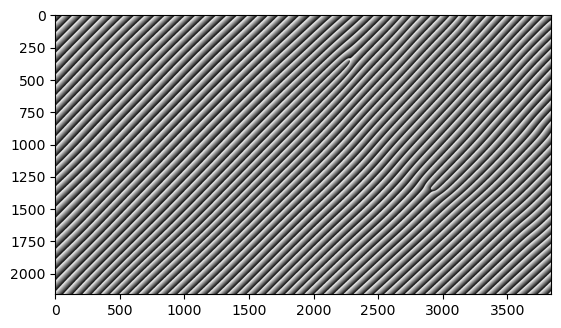

In [20]:
### Initilization ###
# for the light beams 
number_of_rows = 2
number_of_columns = 2
# for the phase pattern 
part_rows = 1
part_columns = 1
# to define a normal distribution of weights depending on the number of rows and columns
# weight = np.ones(number_of_columns * number_of_rows) / (number_of_columns * number_of_rows)

# since we are only using this part to get the LOCATION of the beams, we don't need to specify the weights
weight = np.array([0.25, 0.25, 0.25, 0.25])

# beam waist size
w0 = 10

# distances between each light beams
interval = 200

# the error allowed for which the algorithm to start saving the phase patterns
# if the error is less than the error_allowed, the algorithm will save the phase pattern in the desired file location
error_allowed = 0.12

Dim = np.array([part_rows, part_columns])
#####################

# size_real = np.array([1920, 1080]) 
# using the HOLOEYE GAEA-2, the resolution is 3840 x 2160
size_real = np.array([3840, 2160])
Overall_Pattern = np.zeros((2160, 3840), dtype=np.float64)

size_real = size_real / Dim 
size_real = size_real.astype(int)
temp = np.zeros(number_of_columns * number_of_rows)
temp[:len(weight)] = weight
weight_shaped = np.reshape(temp, (number_of_columns, number_of_rows))
weight_shaped = np.flipud(weight_shaped)

Pattern1 = np.zeros((2160, 3840), dtype=np.float64)

total_part_num = part_rows * part_columns

# beam waist size
w0 = 10

# distances between each light beams
interval = 200

# the error allowed for which the algorithm to start saving the phase patterns
# if the error is less than the error_allowed, the algorithm will save the phase pattern in the desired file location
error_allowed = 0.12

Dim = np.array([part_rows, part_columns])
#####################

# size_real = np.array([1920, 1080]) 
# using the HOLOEYE GAEA-2, the resolution is 3840 x 2160
size_real = np.array([3840, 2160])
Overall_Pattern = np.zeros((2160, 3840), dtype=np.float64)

size_real = size_real / Dim 
size_real = size_real.astype(int)
temp = np.zeros(number_of_columns * number_of_rows)
temp[:len(weight)] = weight
weight_shaped = np.reshape(temp, (number_of_columns, number_of_rows))
weight_shaped = np.flipud(weight_shaped)

Pattern1 = np.zeros((2160, 3840), dtype=np.float64)

total_part_num = part_rows * part_columns

for part in range(1, total_part_num + 1):
    for iteration in range (0, 1):
        # since there is no feedback in this part, the balance is set to 0
        balance = 0
        if iteration == 0:
            [Pattern_part, phi] = gsw_output(size_real, weight_shaped, interval, number_of_rows, number_of_columns, w0, 0)
            Pattern_last = phi
        else:
            [Pattern_part, phi] = gs_iteration_modified(size_real, weight_shaped, interval, Pattern_last, balance, w0)
            Pattern_last = phi

    
    x = int(Dim[0] - 1 - np.mod(part - 1, Dim[0]))
    y = int(np.floor((part - 1) / Dim[0]))  

    start_x = x * size_real[0]
    end_x = (x+1) * size_real[0]
    start_y = y * size_real[1]
    end_y = (y+1) * size_real[1]
 
    Pattern1[start_y : end_y, start_x : end_x] = Pattern_part

# divide each value in Pattern by 2 * pi
Pattern1 = np.mod(Pattern1, 2 * np.pi)

# displaying the phase pattern
plt.imshow(Pattern1, cmap='gray')

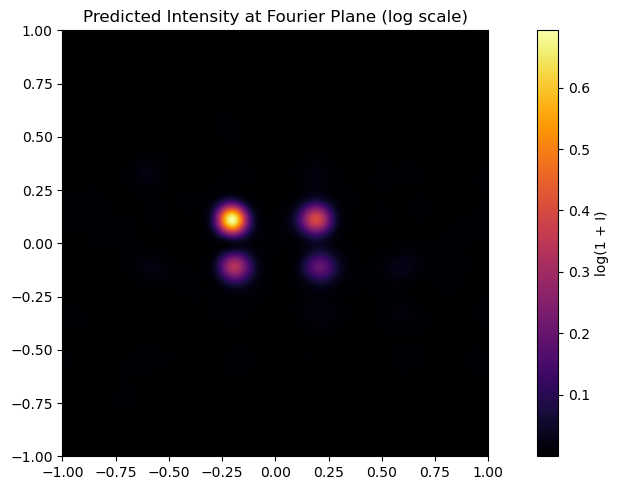

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from scipy.ndimage import zoom

# -------------------------------------------------------------------
# Full Numerical Prediction of Fourier Plane Intensity from Phase Pattern
# -------------------------------------------------------------------

def predict_fourier_output(phase_pattern, w0_pixels=10, intensity_scale=1.0, output_shape=(512, 512)):
    """
    Predict the Fourier-plane output intensity pattern from a phase pattern.

    Parameters
    ----------
    phase_pattern : np.ndarray
        Phase pattern (in radians) to simulate.
    w0_pixels : int
        Beam waist (standard deviation) in pixels for Gaussian input amplitude.
    intensity_scale : float
        Scaling factor for input amplitude.
    output_shape : tuple
        Desired shape for downsampled simulation (e.g., (512, 512)).

    Returns
    -------
    I_f : np.ndarray
        Normalized intensity at the Fourier plane.
    """
    # Step 1: Downsample the phase pattern for numerical efficiency
    downsample_factor = (
        output_shape[0] / phase_pattern.shape[0],
        output_shape[1] / phase_pattern.shape[1]
    )
    phase_small = zoom(phase_pattern, downsample_factor, order=1)

    # Step 2: Generate matching Gaussian amplitude
    H, W = phase_small.shape
    x = np.linspace(-W/2, W/2, W)
    y = np.linspace(-H/2, H/2, H)
    X, Y = np.meshgrid(x, y)
    amplitude = intensity_scale * np.exp(-2 * (X**2 + Y**2) / w0_pixels**2)

    # Step 3: Construct complex field and FFT to simulate lens output
    field = amplitude * np.exp(1j * phase_small)
    E_f = fftshift(fft2(field))
    I_f = np.abs(E_f)**2
    I_f /= np.max(I_f)  # Normalize to 1

    return I_f

I_f_sim = predict_fourier_output(Pattern1)

# Plot result
plt.figure(figsize=(10, 5))
plt.imshow(np.log1p(I_f_sim), cmap='inferno', extent=[-1, 1, -1, 1])
plt.title("Predicted Intensity at Fourier Plane (log scale)")
plt.colorbar(label="log(1 + I)")
plt.tight_layout()
plt.show()
